## Counters

* [`/agas{locality#*/total}/count/bind_gid`](#Bind-GID)
* [`/agas{locality#*/total}/count/unbind_gid`](#Unbind-GID)
* [`/agas{locality#*/total}/count/resolve_gid`](#Resolve-GID)
* [`/agas{locality#*/total}/time/resolve_gid`](#Resolve-GID)
***
* [`/agas{locality#*/total}/count/route`](#Route)
* [`/agas{locality#*/total}/time/route`](#Route)
* [`/agas{locality#*/total}/count/resolve_locality`](#Resolve-Locality)
* [`/agas{locality#*/total}/time/resolve_locality`](#Resolve-Locality)
***
* [`/agas{locality#*/total}/count/decrement_credit`](#Decrement-Credit)
* [`/agas{locality#*/total}/time/decrement_credit`](#Decrement-Credit)
* [`/agas{locality#*/total}/count/increment_credit`](#Increment-Credit)
* [`/agas{locality#*/total}/time/increment_credit`](#Increment-Credit)
***
* [`/agas{locality#*/total}/count/cache/hits`](#AGAS-Cache-Hit-Rate)
* [`/agas{locality#*/total}/count/cache/misses`](#AGAS-Cache-Hit-Rate)
* [`/agas{locality#*/total}/time/cache/insert_entry`](#Insert-Entry)
* [`/agas{locality#*/total}/count/cache/update_entry`](#Update-Entry)
* [`/agas{locality#*/total}/time/cache/update_entry`](#Update-Entry)
* [`/agas{locality#*/total}/time/cache/get_entry`](#Get-Entry)
* [`/agas{locality#*/total}/time/cache/erase_entry`](#Erase-Entry)

### Notebook Preps

In [1]:
%matplotlib inline
%matplotlib notebook
#%matplotlib nbagg

In [2]:
import re

In [3]:
import numpy as np
import pandas as pd
#import scipy as sp

import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

---

## Performance Counter Parsing RegEx

In [4]:
pfx_pattern = re.compile(
    '/([a-z_]+){locality#(\d+)/total}/(?:(?:(count|time)/)'
    '([a-z/_-]+)|([a-z/_-]+)/(?:(count|time))),([0-9]+),'
    '([0-9.]+),\[[a-z]+\],([0-9.\+e]+)(?:,\[([a-z]+)?\])?'
)

## Read the Data Files

In [5]:
import tarfile

In [6]:
dataset = []

with tarfile.open('smic-16apr15.tar.bz2', mode='r:bz2') as arxiv:
    for i in arxiv.getnames():
        if i.endswith('.txt'):
            n_nodes = int(i.split('.')[0])
            fd = arxiv.extractfile(i)
            for m in pfx_pattern.finditer(fd.read()):
                is_rev = m.group(3) != None

                dataset.append({
                    'sys': m.group(1),
                    'proc': (m.group(4) if is_rev else m.group(5)).replace('/', '.'),
                    'type': m.group(3) if is_rev else m.group(6),
                    'locality': int(m.group(2)),
                    'value': float(m.group(9)),
                    'value_unit': m.group(10),
                    'timestamp': m.group(8),
                    'iteration': int(m.group(7)),
                    'nodes': n_nodes,
                })

df = pd.DataFrame(dataset)

### Last Iteration

In [7]:
d = None
for i, j in df[['nodes', 'iteration']].groupby('nodes').max().iteration.to_dict().iteritems():
    x = df[(df.nodes==i) & (df.iteration==j)]
    if d is None:
        d = x
    else:
        d = pd.concat([d, x])

In [8]:
print d[(d.sys=='agas') & (d.type=='count')].proc.unique()
print d[(d.sys=='agas') & (d.type=='time')].proc.unique()

['allocate' 'begin_migration' 'bind' 'bind_gid' 'cache.erase_entry'
 'cache.evictions' 'cache.get_entry' 'cache.hits' 'cache.insert_entry'
 'cache.insertions' 'cache.misses' 'cache.update_entry' 'decrement_credit'
 'end_migration' 'increment_credit' 'iterate_names'
 'on_symbol_namespace_event' 'resolve' 'resolve_gid' 'route' 'unbind'
 'unbind_gid' 'primary' 'symbol' 'bind_name' 'bind_prefix' 'free'
 'get_component_typename' 'iterate_types' 'localities' 'num_localities'
 'num_localities_type' 'num_threads' 'resolve_id' 'resolve_locality'
 'resolved_localities' 'unbind_name' 'locality' 'component']
['primary' 'symbol' 'allocate' 'begin_migration' 'bind' 'bind_gid'
 'cache.erase_entry' 'cache.get_entry' 'cache.insert_entry'
 'cache.update_entry' 'decrement_credit' 'end_migration' 'increment_credit'
 'iterate_names' 'on_symbol_namespace_event' 'resolve' 'resolve_gid'
 'route' 'unbind' 'unbind_gid' 'locality' 'component' 'bind_name'
 'bind_prefix' 'free' 'get_component_typename' 'iterate_ty

---

## GIDs

### Bind GID

<IPython.core.display.Javascript object>


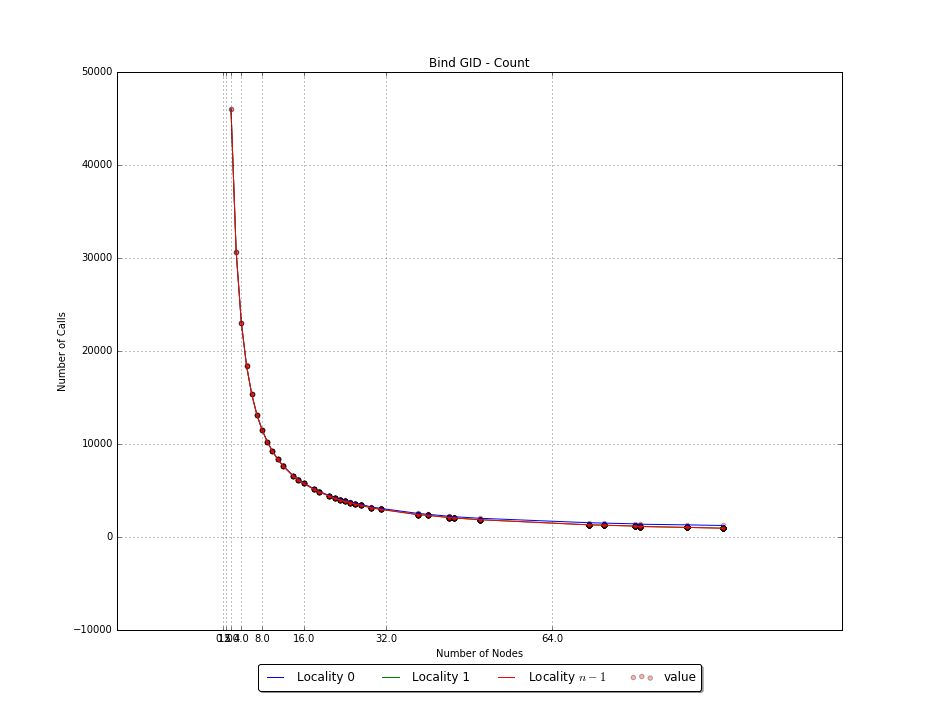

In [9]:
crt = d[(d.sys=='agas') & (d.proc=='bind_gid') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Bind GID - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))

### Unbind GID

<IPython.core.display.Javascript object>


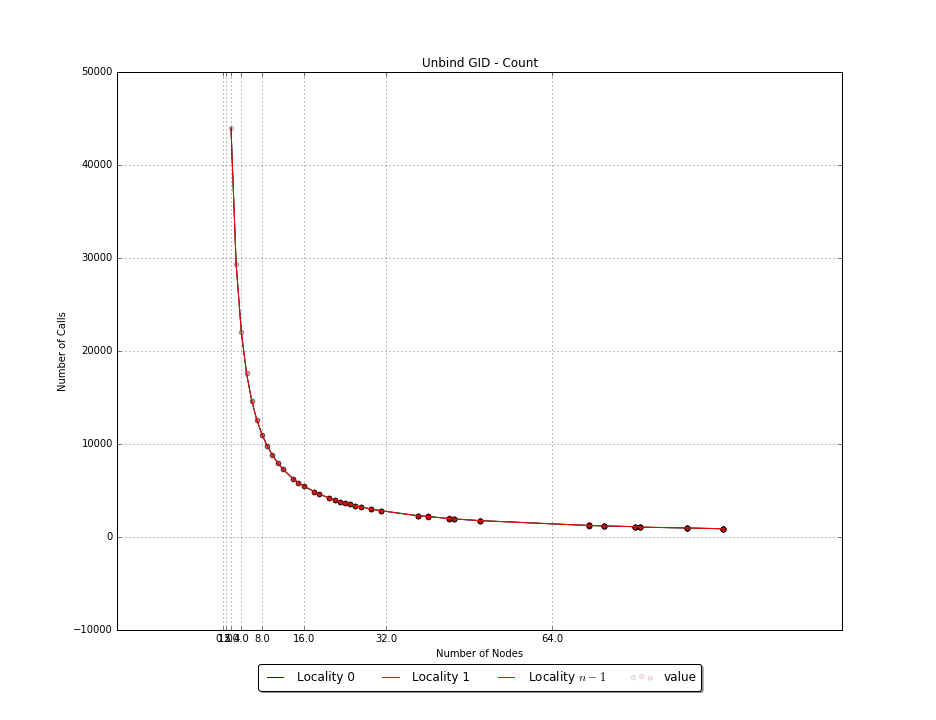

In [10]:
crt = d[(d.sys=='agas') & (d.proc=='unbind_gid') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.1)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Unbind GID - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))

### Resolve GID

<IPython.core.display.Javascript object>


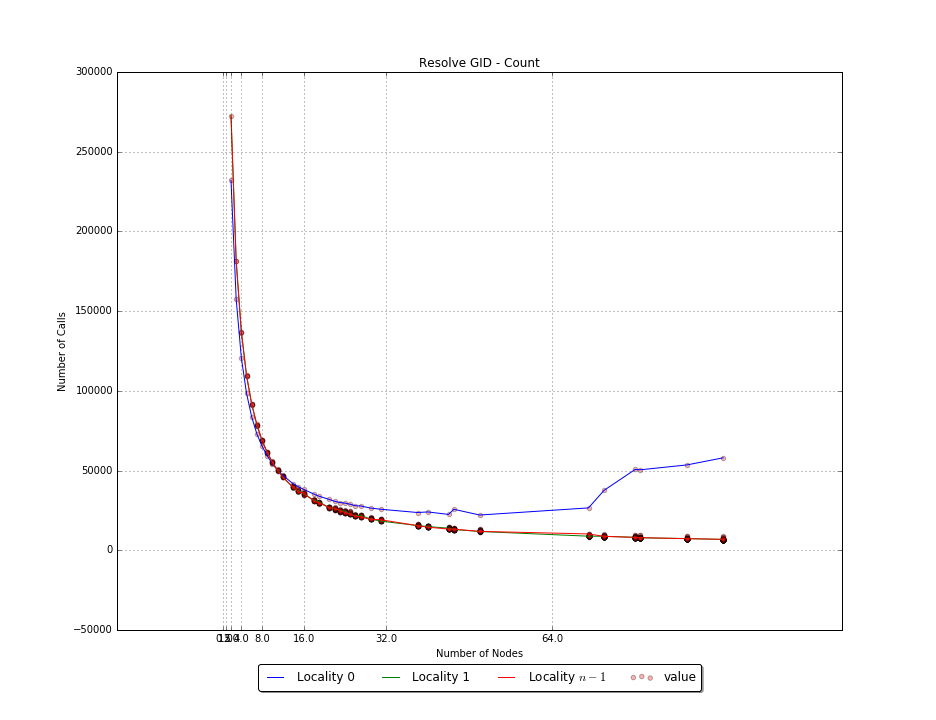

In [11]:
crt = d[(d.sys=='agas') & (d.proc=='resolve_gid') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Resolve GID - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))

[^ TOC ^](#Counters)

---

## Locality Namespace

### Route

<IPython.core.display.Javascript object>


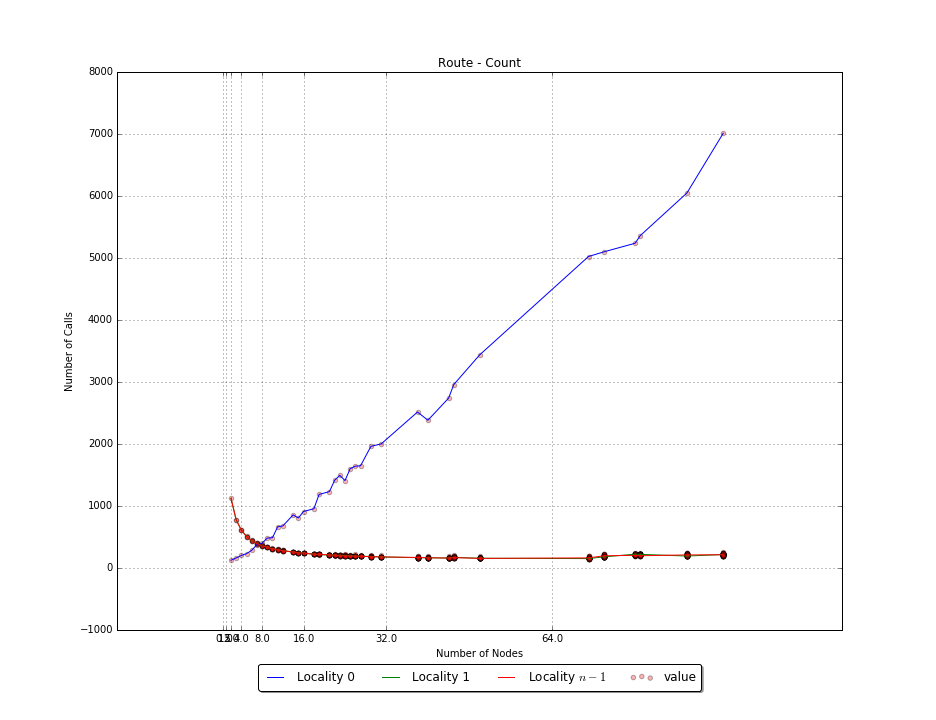

In [12]:
crt = d[(d.sys=='agas') & (d.proc=='route') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Route - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))

<IPython.core.display.Javascript object>


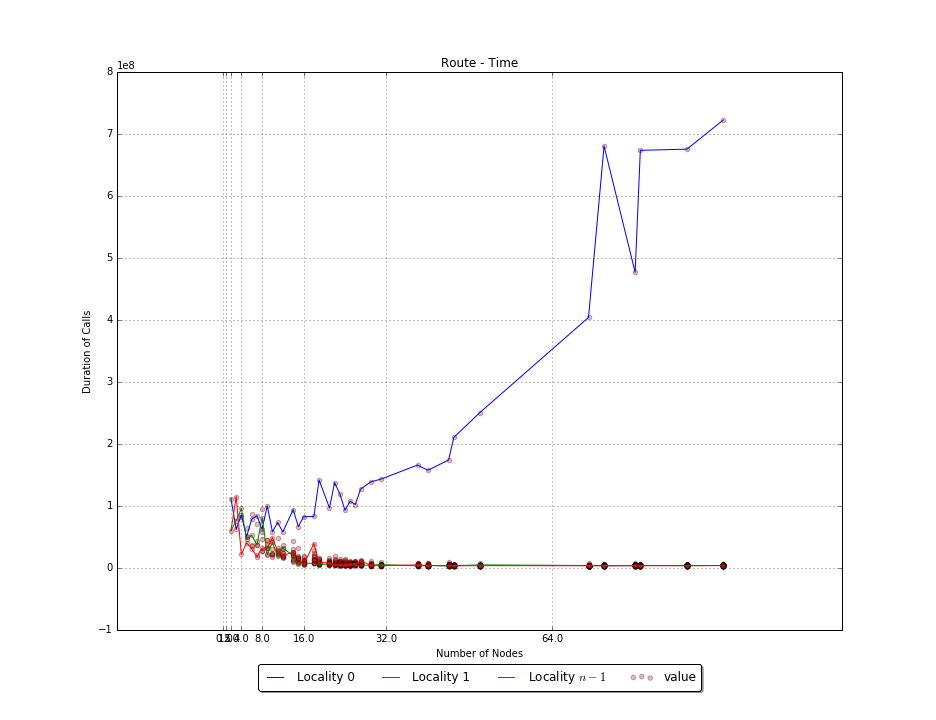

In [13]:
crt = d[(d.sys=='agas') & (d.proc=='route') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Route - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))

[^ TOC ^](#Counters)

### Resolve Locality

<IPython.core.display.Javascript object>


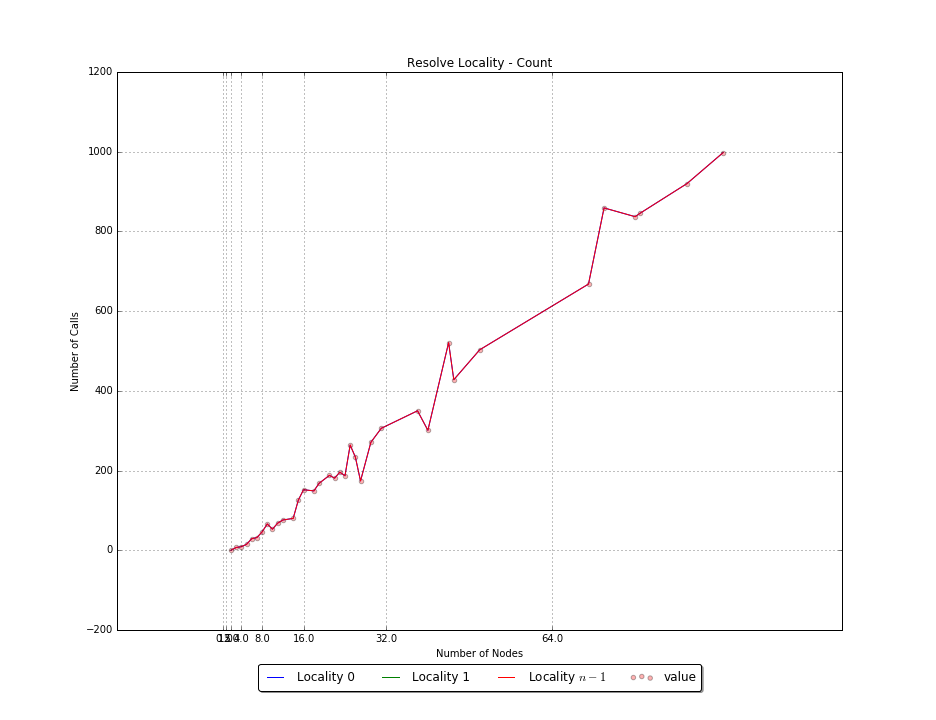

In [14]:
crt = d[(d.sys=='agas') & (d.proc=='resolve_locality') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Resolve Locality - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))

<IPython.core.display.Javascript object>


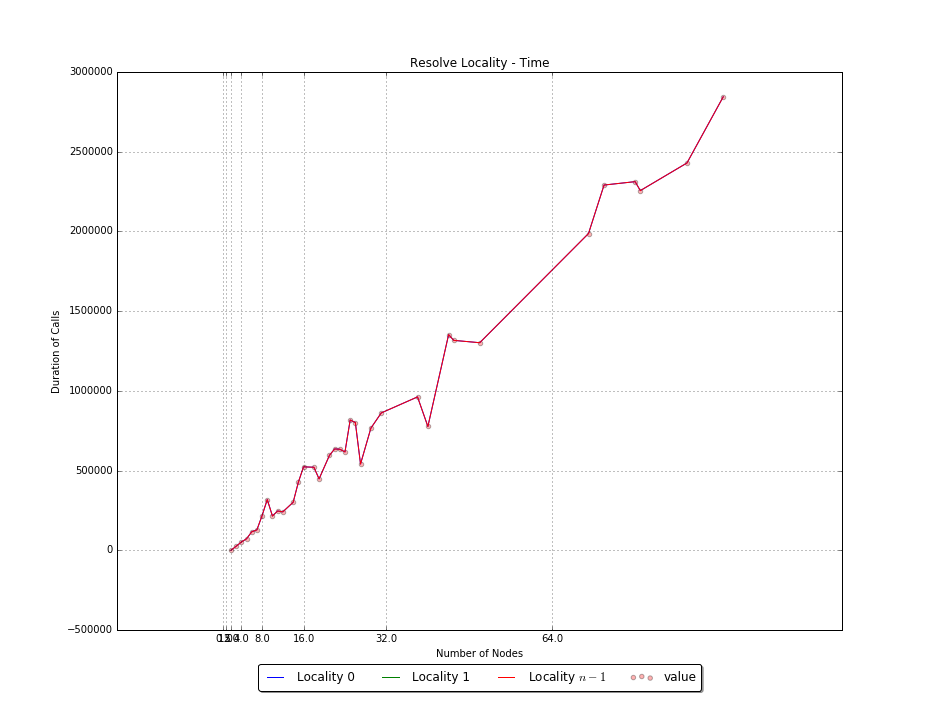

In [15]:
crt = d[(d.sys=='agas') & (d.proc=='resolve_locality') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Resolve Locality - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))

[^ TOC ^](#Counters)

---

## Garbage Collection

### Increment Credit

<IPython.core.display.Javascript object>


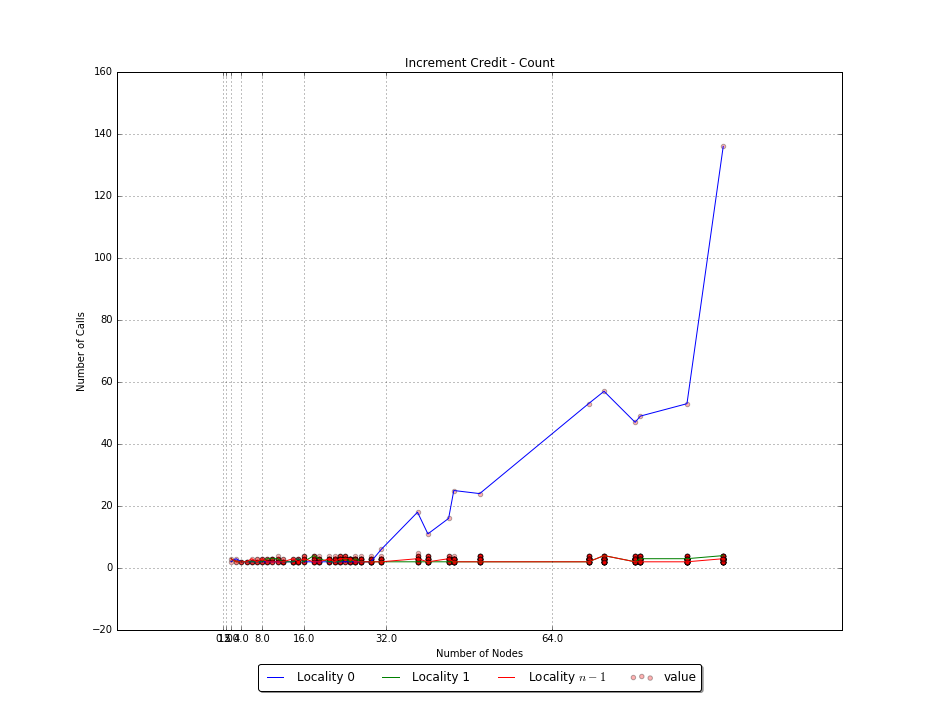

In [16]:
crt = d[(d.sys=='agas') & (d.proc=='increment_credit') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Increment Credit - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))

<IPython.core.display.Javascript object>


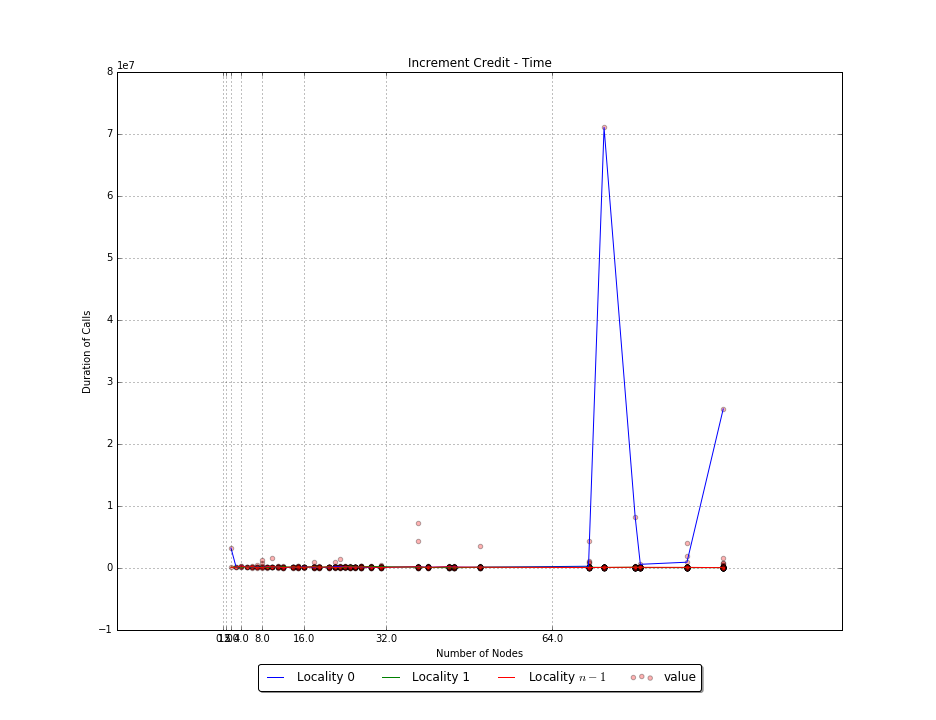

In [17]:
crt = d[(d.sys=='agas') & (d.proc=='increment_credit') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Increment Credit - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))

[^ TOC ^](#Counters)

### Decrement Credit

<IPython.core.display.Javascript object>


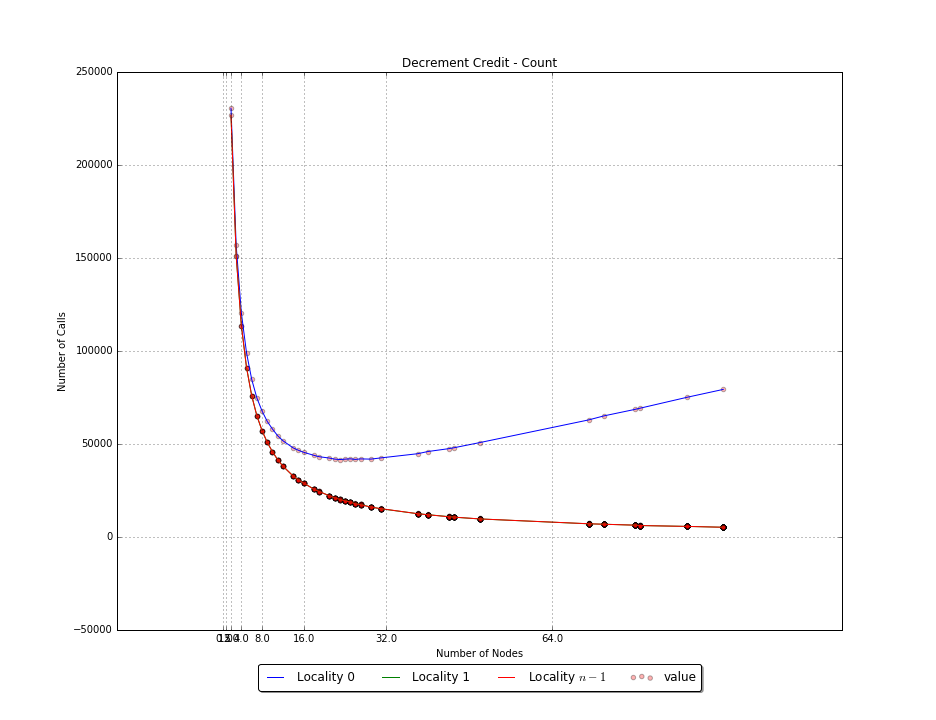

In [18]:
crt = d[(d.sys=='agas') & (d.proc=='decrement_credit') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Decrement Credit - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))

<IPython.core.display.Javascript object>


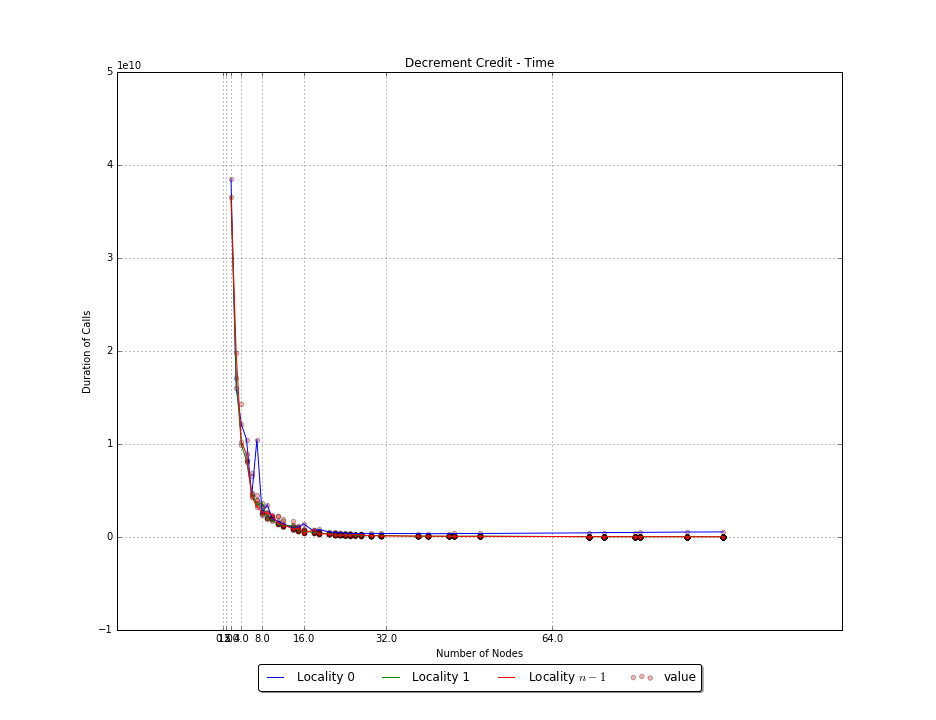

In [19]:
crt = d[(d.sys=='agas') & (d.proc=='decrement_credit') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Decrement Credit - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))

[^ TOC ^](#Counters)

---

## AGAS Cache

### AGAS Cache Hit Rate

* $\textit{hits}: \mathtt{/agas\{locality\#*/total\}/count/cache/hits}$
* $\textit{misses}: \mathtt{/agas\{locality\#*/total\}/count/cache/misses}$

$$
\textit{miss rate} = \frac{\textit{misses}}{\textit{misses} + \textit{hits}}
$$

<IPython.core.display.Javascript object>


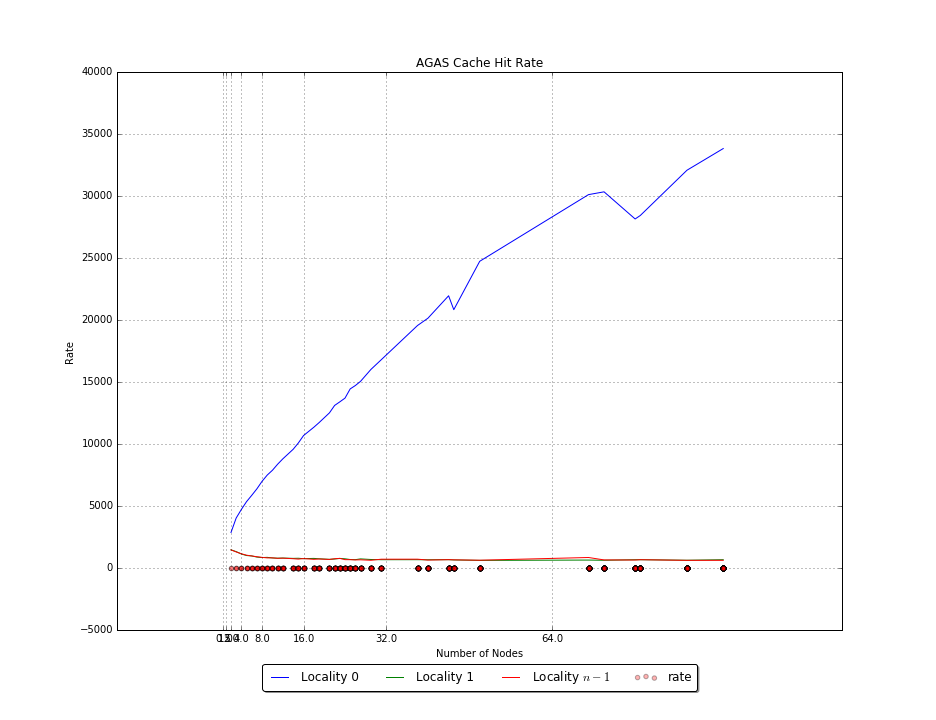

In [20]:
crt_h = d[(d.sys=='agas') & (d.proc=='cache.hits') & (d.type=='count')]
crt_m = d[(d.sys=='agas') & (d.proc=='cache.misses') & (d.type=='count')]

crt_m = crt_m.set_index(crt_h.index)

crt = crt_h[['nodes', 'value', 'locality']]
crt.is_copy = False # Disable the warning
crt['rate'] = crt_h.value / (crt_h.value + crt_m.value)

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.rate, c='r', alpha=.3)

t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')

t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Cache Hit Rate')
plt.xlabel('Number of Nodes')
plt.ylabel('Rate')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))

[^ TOC ^](#Counters)

### Insert Entry

<IPython.core.display.Javascript object>


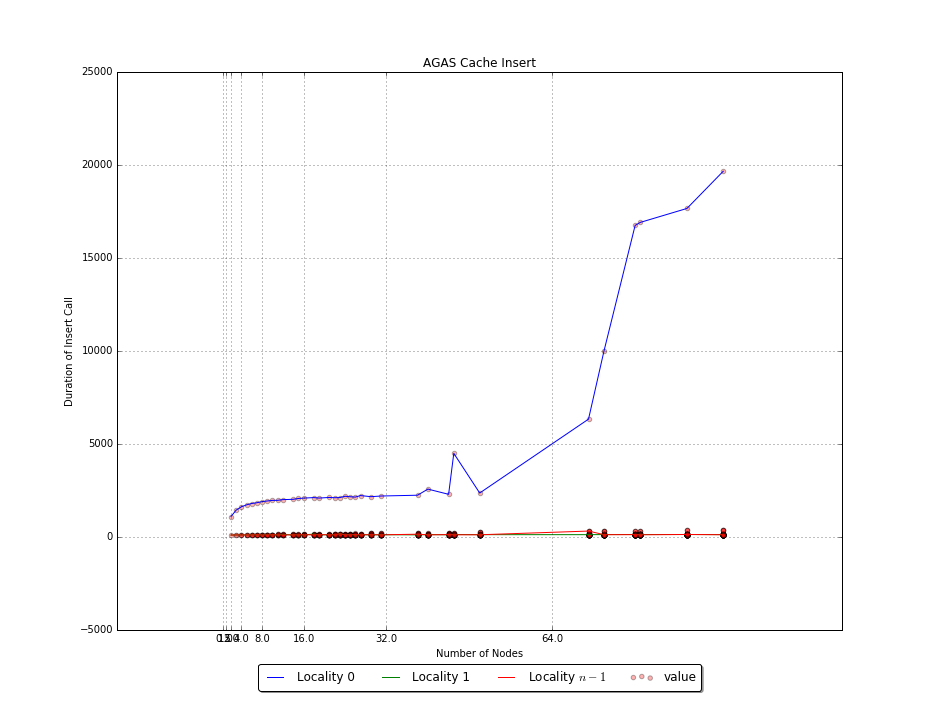

In [21]:
crt = d[(d.sys=='agas') & (d.proc=='cache.insert_entry') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')

t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Cache Insert')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Insert Call')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))

[^ TOC ^](#Counters)

### Erase Entry

<IPython.core.display.Javascript object>


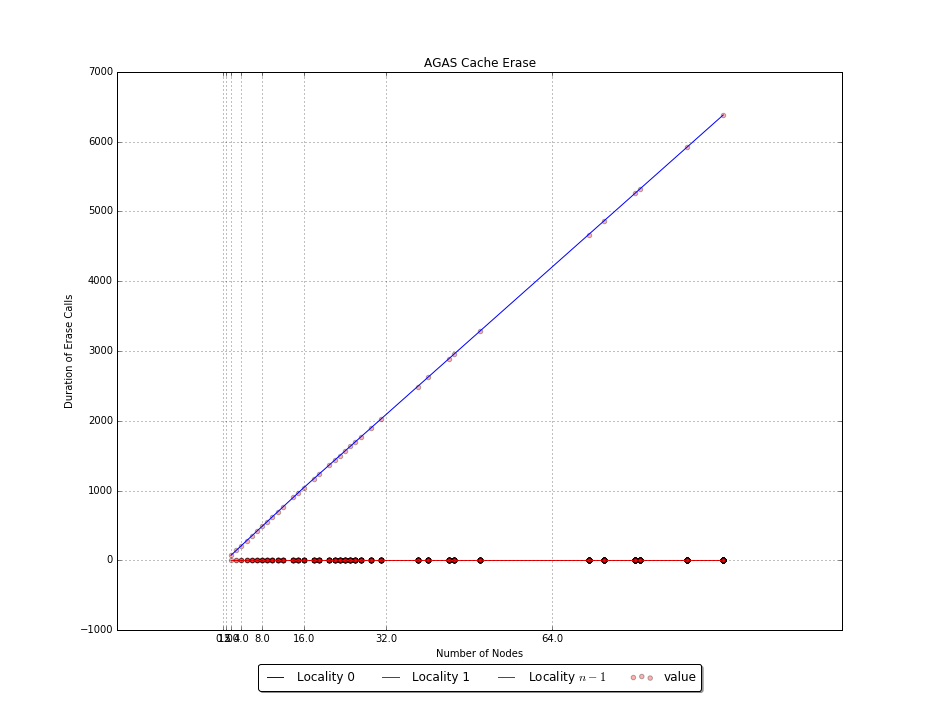

In [22]:
crt = d[(d.sys=='agas') & (d.proc=='cache.erase_entry') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')

t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Cache Erase')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Erase Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))

[^ TOC ^](#Counters)

### Get Entry

<IPython.core.display.Javascript object>


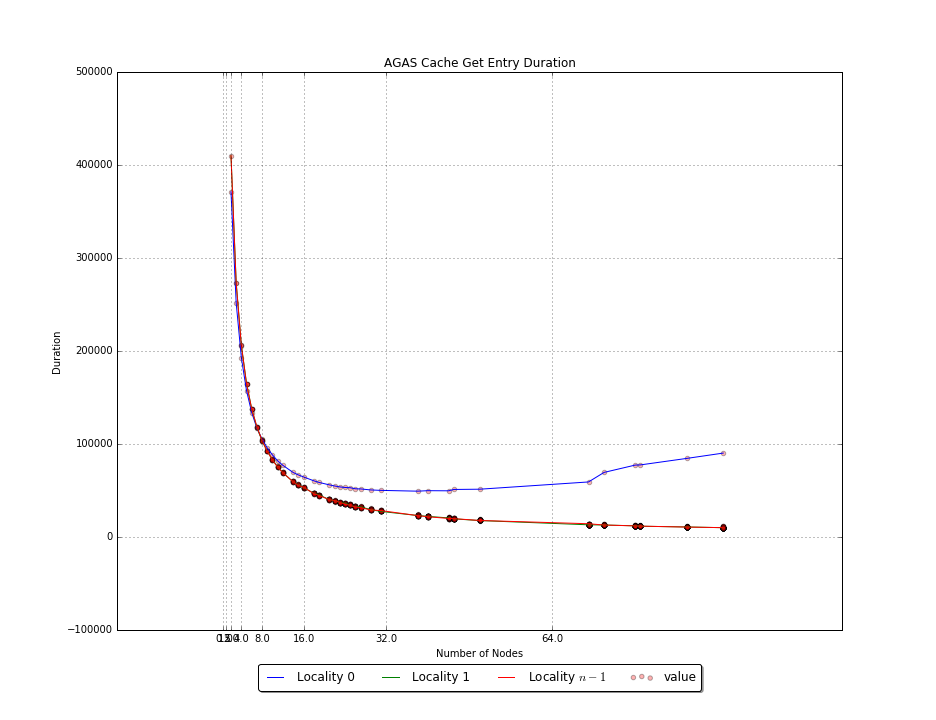

In [23]:
crt = d[(d.sys=='agas') & (d.proc=='cache.get_entry') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')

t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Cache Get Entry Duration')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))

[^ TOC ^](#Counters)

### Update Entry

<IPython.core.display.Javascript object>


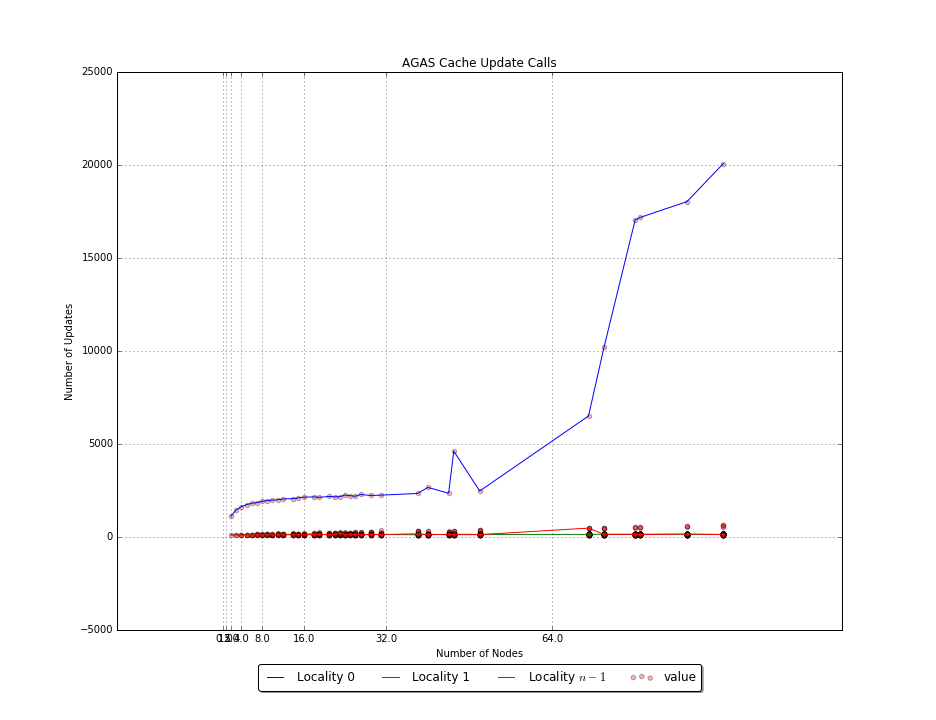

In [24]:
crt = d[(d.sys=='agas') & (d.proc=='cache.update_entry') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')

t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Cache Update Calls')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Updates')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))

<IPython.core.display.Javascript object>


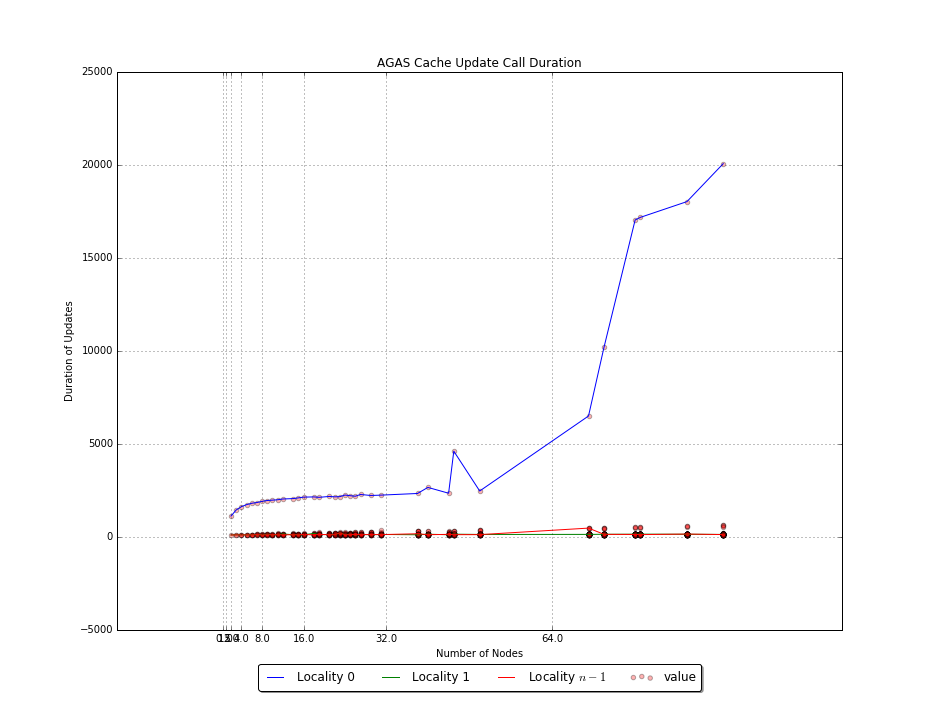

In [25]:
crt = d[(d.sys=='agas') & (d.proc=='cache.update_entry') & (d.type=='time')]

if crt.size > 0:
    plt.figure(figsize=(13, 10))
    plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

    t = crt[crt.locality==0]
    plt.plot(t.nodes, t.value, label='Locality 0')

    t = crt[crt.locality==1]
    plt.plot(t.nodes, t.value, label='Locality 1')
    #
    t = crt.groupby('nodes', as_index=False).last()
    plt.plot(t.nodes, t.value, label='Locality $n - 1$')
    #
    plt.grid()

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    plt.title('AGAS Cache Update Call Duration')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Duration of Updates')

    plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))

---

# Miscellaneous

### Save Dataset to disk

```python
df.to_hdf('./pfx_data.hdf', 'table', mode='w', table=True)
```

[^ TOC ^](#Counters)